In [2]:
import wandb
wandb.init(project='33_ddpm_3q',name='note_half_test')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"


# Standard libraries
import os
import tempfile
import time
import io
import random
import math
import warnings
from multiprocessing import Manager
from typing import Optional

# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, random_split

# MONAI libraries
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Other medical image processing libraries
import SimpleITK as sitk
import torchio as tio

# Plotting and visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Custom modules
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet_2Q
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

# Weights and Biases for experiment tracking
from dataloader import Train,Eval






config = {
    'batch_size': 4,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 0, 
    'perc_high': 100,
    'rescaleFactor':2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hale-akrami (usc_akrami). Use `wandb login --relogin` to force relogin


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [3]:
wandb.config.update(config )


imgpath = {}
# '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv'
#'/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv',
#csvpath_trains = ['/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv', '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv']
csvpath_trains=['./combined.csv']
pathBase = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data_train'
csvpath_val = '/acmenas/hakrami/3D_lesion_DF/splits/IXI_train_fold0.csv'
csvpath_test = '/acmenas/hakrami/3D_lesion_DF/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# dfffff=  pd.concat(df_list, ignore_index=True)
# dfffff.to_csv("./combined.csv", index=False)

In [4]:
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = pathBase  + var_csv[state]['norm_path']
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

model = DiffusionModelUNet_2Q(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model_filename = '/acmenas/hakrami/3D_lesion_DF/models/half_3Q/model_epoch49.pt'
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.load_state_dict(torch.load(model_filename),strict = False)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)


n_epochs = 50
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()


wandb.watch(model, log_freq=100)

Using 4 GPUs!


[]

In [5]:
# scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

# inferer = DiffusionInferer(scheduler)

# optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)



# epoch_loss_list = []
# val_epoch_loss_list = []

# scaler = GradScaler()
# total_start = time.time()
# n_epochs = config.get('n_epochs',100)
# val_interval =config.get('val_interval',5)

Epoch 0:   0%|                               | 0/2410 [00:00<?, ?it/s]

Epoch 24: 100%|██████| 2410/2410 [15:28<00:00,  2.59it/s, loss=0.0158]


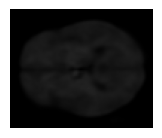

<Figure size 640x480 with 0 Axes>

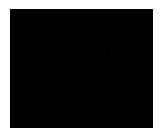

<Figure size 640x480 with 0 Axes>

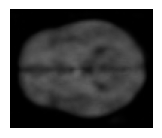

Epoch 49: 100%|██████| 2410/2410 [13:55<00:00,  2.89it/s, loss=0.0148]


<Figure size 640x480 with 0 Axes>

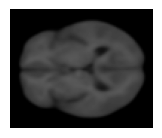

<Figure size 640x480 with 0 Axes>

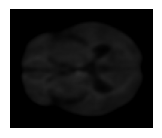

<Figure size 640x480 with 0 Axes>

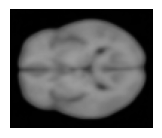

Epoch 55:  65%|███▉  | 1558/2410 [04:49<02:38,  5.39it/s, loss=0.0149]


RuntimeError: DataLoader worker (pid(s) 708377) exited unexpectedly

<Figure size 640x480 with 0 Axes>

: 

In [6]:



class QuantileLoss(nn.Module):
    def __init__(self, quantile=0.5, reduction='mean'):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile
        self.reduction = reduction

    def forward(self, preds, target):
        assert preds.size() == target.size()
        diff = target - preds
        loss = torch.where(diff >= 0, self.quantile * diff, (self.quantile - 1) * diff)
        if self.reduction =='mean':
            return torch.mean(loss)
        else:
            return torch.mean(loss, dim=(1, 2, 3))
            

quantile_loss_l = QuantileLoss(quantile=0.05)
quantile_loss_m = QuantileLoss(quantile=0.5)
quantile_loss_h = QuantileLoss(quantile=0.95)

epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
n_epochs = config.get('n_epochs',1000)
val_interval =config.get('val_interval',25)

wandb.watch(model, log_freq=100)
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
       # images = batch["image"].to(device)
        images = batch['vol']['data'].to(device)
        images  = torch.rand(1).item()* images
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            prediction,prediction_m,prediction_h = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = quantile_loss_l(prediction, images) + quantile_loss_m(prediction_m, images) + quantile_loss_h(prediction_h, images)

            #loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    wandb.log({"loss_train": epoch_loss / (step + 1)},step=epoch)


    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch['vol']['data'].to(device)
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    # Get model prediction
                    prediction,prediction_m,prediction_h = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = quantile_loss_l(prediction, images) + quantile_loss_m(prediction_m, images) + quantile_loss_h(prediction_h, images)

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        wandb.log({"loss_val": val_epoch_loss / (step + 1)},step=epoch)

        # Sampling image during training
        #80, 96, 80
        image = torch.randn_like(images)[0:1,:,:,:]
        image = image.to(device)
        noise = torch.randn_like(images).to(device)
        timesteps = torch.randint(
                        inferer.scheduler.num_train_timesteps-1, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
        with autocast(enabled=True):
            prediction,prediction_m,prediction_h = inferer(inputs=image, diffusion_model=model, noise=noise, timesteps=timesteps)


        middle_slice_idx = int(image.size(-1) // 2)
        plt.figure(figsize=(2, 2))
        plt.imshow(prediction_m[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        wandb.log({"sample_image_m": [wandb.Image(plt)]},step=epoch)
        filename = f"./results/half_norm_3Q/sample_epoch{epoch}.png"
        plt.savefig(filename, dpi=300) 


        plt.figure(figsize=(2, 2))
        plt.imshow(prediction[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        wandb.log({"sample_image_l": [wandb.Image(plt)]},step=epoch)

        plt.figure(figsize=(2, 2))
        plt.imshow(prediction_h[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        wandb.log({"sample_image_h": [wandb.Image(plt)]},step=epoch)
        # Modify the filename to include the epoch number
        

         
        # Save the model
        model_filename = f"./models/half_3Q/model_epoch{epoch}.pt"
        torch.save(model.state_dict(), model_filename)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")



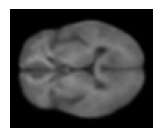

<Figure size 640x480 with 0 Axes>

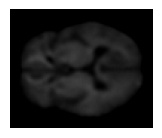

<Figure size 640x480 with 0 Axes>

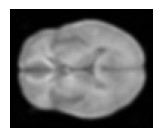

<Figure size 640x480 with 0 Axes>

In [10]:
middle_slice_idx = int(image.size(-1) // 2)
plt.figure(figsize=(2, 2))
plt.imshow(prediction_m[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
wandb.log({"sample_image_m": [wandb.Image(plt)]},step=epoch)
filename = f"./results/half_norm_3Q/sample_epoch{epoch}.png"
plt.savefig(filename, dpi=300) 


plt.figure(figsize=(2, 2))
plt.imshow(prediction[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
wandb.log({"sample_image_l": [wandb.Image(plt)]},step=epoch)

plt.figure(figsize=(2, 2))
plt.imshow(prediction_h[0, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
wandb.log({"sample_image_h": [wandb.Image(plt)]},step=epoch)
# Modify the filename to include the epoch number


    
# Save the model
model_filename = f"./models/half_3Q/model_epoch{epoch}.pt"
torch.save(model.state_dict(), model_filename)